In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from bgtorch.utils.types import assert_numpy

In [3]:
from bgtorch.nn.training import KLTrainer

In [4]:
from bgtorch.nn import DenseNet
from bgtorch.nn.flow import (
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow,
    MergeFlow,
    InverseFlow, 
    SwapFlow
)
from bgtorch.nn.flow.transformer import AffineTransformer

In [5]:
from bgtorch import BoltzmannGenerator

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [7]:
plt.rcParams.update({'font.size': 16})

In [8]:
from bgtorch.distribution.energy.base import Energy
from bgtorch.distribution.energy import DoubleWellEnergy
from bgtorch.distribution import NormalDistribution

In [104]:
from snf_code import InterpolatedEnergy, RNVP, boltzmann_generator_RNVP_MC
from snf_code.analysis import sample_energy, statistical_efficiency
from snf_code.imagetools import boltzmann_generator_NSF_MC

Basic functions
----

In [10]:
def sample_flow(flow, x0, inverse=False):
    blocks = flow._blocks
    samples = [x0]
    x = [x0]
    if inverse:
        blocks = blocks[::-1]
    for block in blocks:
        *x, ddlogp = block(*x, inverse=inverse)
        if not (isinstance(block, SplitFlow) or isinstance(block, SwapFlow) or isinstance(block, MergeFlow)):
            #print(block)
            x_np = [xi.detach().numpy() for xi in x]
            samples.append(np.hstack(x_np))
    if inverse:
        samples = samples[::-1]
    return samples

In [11]:
def plot_samples(samples, weights=None, range=None, ax=None):
    """ Plot sample histogram in 2D """
    samples = assert_numpy(samples)
    if ax is None:
        ax = plt.gca()
    ax.hist2d(
        samples[:, 0], 
        -samples[:, 1],
        weights=assert_numpy(weights) if weights is not None else weights,
        bins=100,
        norm=mpl.colors.LogNorm(),
        range=range
    )

In [71]:
def bias_uncertainty(target_energy, x, energies, w_x, w_energies):
    X = torch.Tensor(np.vstack([x, np.zeros((1, len(x)))]).T)
    E_target = target_energy.energy(X)[:, 0]
    E_target -= E_target.min()

    # unweighted
    E_mean = np.mean(energies, axis=0)
    E_mean -= E_mean.min()

    # weighted
    Ew_mean = np.mean(w_energies, axis=0)
    Ew_mean -= Ew_mean.min()

    I = np.logical_and(x > -2.25, x < 2.25)
    # bias
    bias_unweighted = E_target - E_mean
    bias_unweighted = bias_unweighted.detach().numpy()
    J = np.isfinite(bias_unweighted)
    bias_unweighted = np.abs(bias_unweighted[I*J].mean())
    bias_reweighted = E_target - Ew_mean
    bias_reweighted = bias_reweighted.detach().numpy()
    J = np.isfinite(bias_reweighted)
    bias_reweighted = np.abs(bias_reweighted[I*J].mean())
    # uncertainty
    std_unweighted = np.array(energies)[:, I*J].std(axis=0).mean()
    std_reweighted = np.array(w_energies)[:, I*J].std(axis=0).mean()

    return bias_unweighted, std_unweighted, bias_reweighted, std_reweighted

In [117]:
def plot_energy(target_energy, x, energies, w_x, w_energies, ylabel=False, nstd=2.0, figsize=(4, 4)):
    fig = plt.figure(figsize=figsize)
    
    X = torch.Tensor(np.vstack([np.linspace(-3, 3, num=100), np.zeros((1, 100))]).T)
    E_target = target_energy.energy(X)
    E_target -= E_target.min()
    plt.plot(X[:, 0], E_target, linewidth=3, color='#444444')

    # unweighted
    E_mean = np.mean(energies, axis=0)
    E_mean -= E_mean.min()
    plt.errorbar(x, E_mean, nstd*np.std(energies, axis=0), color='red', linewidth=2)
    
    # weighted
    Ew_mean = np.mean(w_energies, axis=0)
    Ew_mean -= Ew_mean.min()
    plt.errorbar(w_x, Ew_mean, nstd*np.std(w_energies, axis=0), color='green', linewidth=2)
    
    plt.ylim(-1, 14)
    plt.xlabel('$x_1$')
    if ylabel:
        plt.ylabel('Energy (kT)')
    else:
        plt.yticks([])
    return fig

System and Data
-----

In [13]:
prior = NormalDistribution(2)
target = DoubleWellEnergy(2, a=-0.5, b=-6)

In [14]:
from bgtorch.distribution.sampling.mcmc import GaussianMCMCSampler

In [15]:
sampler_left = GaussianMCMCSampler(target, noise_std=0.2, init_state=torch.Tensor([[-2, 0]]), n_stride=10)
x_left = sampler_left.sample(10000)

sampler_right = GaussianMCMCSampler(target, noise_std=0.2, init_state=torch.Tensor([[2, 0]]), n_stride=10)
x_right = sampler_right.sample(10000)

x_both = torch.cat([x_left, x_right], dim=0)

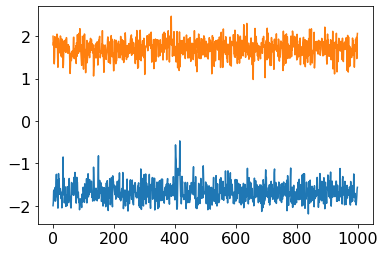

In [16]:
plt.plot(x_left[:, 0])
plt.plot(x_right[:, 0])

In [17]:
# exact sample
brute_sampler = GaussianMCMCSampler(target, init_state=torch.tensor([[-2., 0]]), noise_std=1.5, n_stride=1)
x_brute = brute_sampler.sample(100000)

Text(-4.5, 4, 'c')

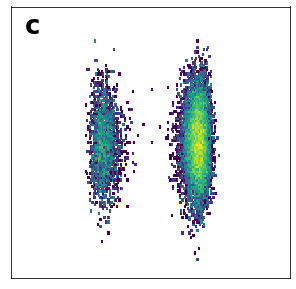

In [18]:
fig = plt.figure(figsize=(5, 5))
plot_samples(x_brute[::2], ax=plt.gca())
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xticks([])
plt.yticks([])
plt.text(-4.5, 4, 'c', fontsize=26, fontweight='bold')

Bias versus Variance
------

In [24]:
#data = x_both
data = x_brute

bg = boltzmann_generator_RNVP_MC(prior, target, n_transform=3, shift_nhidden=[64, 64], scale_nhidden=[64, 64],
                                 stochastic=False)
trainer = KLTrainer(bg, train_likelihood=True, train_energy=True,
                    optim=torch.optim.Adam(bg.parameters(), lr=0.005))

trainer.train(300, data=data, batchsize=128, w_likelihood=1, w_energy=0, n_print=0)
trainer.train(300, data=data, batchsize=128, w_likelihood=0.5, w_energy=0.5, n_print=0)

In [25]:
hist_x, hists_y, whist_x, whists_y = sample_energy(bg, 100000, 20, nbins=30)

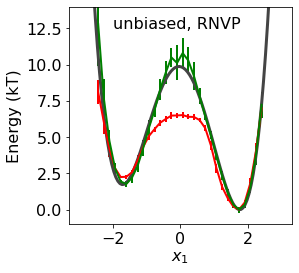

In [26]:
fig = plot_energy(target, hist_x, hists_y, whist_x, whists_y, ylabel=True, nstd=1.0)
plt.text(-2, 12.5, 'unbiased, RNVP', fontsize=16);

Train and analyze several times (statistics)
---

In [63]:
def train_and_analyze(bg, data):
    trainer = KLTrainer(bg, train_likelihood=True, train_energy=True,
                        optim=torch.optim.Adam(bg.parameters(), lr=0.005))

    trainer.train(300, data=data, batchsize=128, w_likelihood=1, w_energy=0, n_print=0)
    trainer.train(300, data=data, batchsize=128, w_likelihood=0.5, w_energy=0.5, n_print=0)
    #trainer_unbiased_MC.train(200, data=x_brute, batchsize=128, w_likelihood=0, w_energy=1, n_print=0)

    se, ses = statistical_efficiency(bg, n_samples=50000, n_resample=1000)

    hist_x, hists_y, whist_x, whists_y = sample_energy(bg, 100000, 20, nbins=30)
    bias, std, bias_w, std_w = bias_uncertainty(target, hist_x, hists_y, whist_x, whists_y)
    
    return [bias, std, bias_w, std_w]

In [188]:
# RNVP unbiased
stats_RNVP = []
for i in range(10):
    bg_unbiased_RNVP = boltzmann_generator_RNVP_MC(prior, target, n_transform=3, shift_nhidden=[64, 64], scale_nhidden=[64, 64],
                                                   stochastic=False)
    stat = train_and_analyze(bg_unbiased_RNVP, x_brute[::10])
    stats_RNVP.append(stat)
    print(i, '\t', stat[0], '\t', stat[1], '\t', stat[2], '\t', stat[3])     
stats_RNVP = np.array(stats_RNVP)

/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:21: RuntimeWarning: divide by zero encountered in log
  hists_y.append(-np.log(hist_y))
/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:26: RuntimeWarning: divide by zero encountered in log
  whists_y.append(-np.log(whist_y))


0 	 0.5661282938879917 	 0.4579434841863185 	 1.4946164391891008 	 1.4099297337993406
1 	 2.133426878599305 	 0.6524967824448923 	 0.5921865775951745 	 1.89990160962148
2 	 1.7755007124054865 	 0.4230044577249629 	 0.09268679458331566 	 0.8917648206372034
3 	 1.5047933679275982 	 0.415654194862915 	 0.7086175903899881 	 1.2400089951266615
4 	 2.653036115989098 	 0.23707906515720356 	 0.05689624340713735 	 0.738793298633857
5 	 1.3879270152864207 	 0.41145794395399277 	 0.10139354187258819 	 1.352202154263435
6 	 1.430966966932708 	 0.23505804522658305 	 0.48488710078813824 	 0.7183461193707584
7 	 1.7607953996166978 	 0.552037626458715 	 0.14066299675838312 	 1.6400543044896627
8 	 0.7571423415373764 	 0.8066178047571878 	 0.7795186562365927 	 3.0988853737801842
9 	 2.222198949698099 	 0.47239194007967933 	 0.024379694958493334 	 0.9720038777897165


In [126]:
stats = stats_RNVP
print('    Bias       Unc        Bias rew   Unc rew')
print('  ', np.mean(stats, axis=0))
print('+-', np.std(stats, axis=0))
print()
ee_unweighted = np.sqrt(stats[:, 0]**2+stats[:, 1]**2)
ee_reweighted = np.sqrt(stats[:, 2]**2+stats[:, 3]**2)
print('bias**2+std**2\t', np.mean(ee_unweighted), '+-', np.std(ee_unweighted))
print('reweighted    \t', np.mean(ee_reweighted), '+-', np.std(ee_reweighted))

    Bias       Unc        Bias rew   Unc rew
   [1.36531919 0.42413064 0.26491827 1.10975499]
+- [0.55081612 0.08578264 0.20900796 0.39271822]

bias**2+std**2	 1.4412990878903007 +- 0.5266851828237653
reweighted    	 1.1525464346390262 +- 0.41386768557111836


Text(-4.5,4,'a')

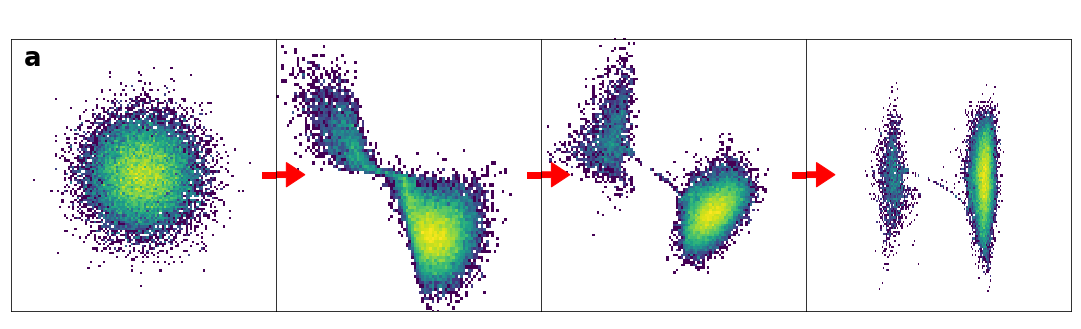

In [21]:
# Visualize flow
z = prior.sample(20000, temperature=1.0)
samples_RNVP_forward = sample_flow(bg_unbiased_RNVP.flow, z, inverse=False)
samples_RNVP_forward[2] = np.hstack([samples_RNVP_forward[2][:, 1:2], samples_RNVP_forward[2][:, 0:1]])
samples_RNVP_forward[4] = np.hstack([samples_RNVP_forward[4][:, 1:2], samples_RNVP_forward[4][:, 0:1]])
samples_RNVP_forward[6] = np.hstack([samples_RNVP_forward[6][:, 1:2], samples_RNVP_forward[6][:, 0:1]])

indx = [0, 2, 4, 6]
fig, axes = plt.subplots(nrows=1, ncols=len(indx), sharex=True, sharey=True, figsize=(19, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.0)
axes[0].set_yticks([])
for i in range(len(indx)):
    plot_samples(samples_RNVP_forward[indx[i]], ax=axes[i])
    axes[i].set_xlim(-5, 5)
    axes[i].set_ylim(-5, 5)
    axes[i].set_xticks([])
    if i > 0:
        arr = axes[i].arrow(-5, 0, 0.4, 0, width=0.21, head_width=0.9, head_length=0.7, color='red')
    if i < len(indx)-1:
        arr = axes[i].plot([4.6, 5], [0, 0], linewidth=7, color='red')
axes[0].text(-4.5, 4, 'a', fontsize=26, fontweight='bold')


In [131]:
bg_unbiased_RNVP = boltzmann_generator_RNVP_MC(prior, target, n_transform=3, shift_nhidden=[64, 64], scale_nhidden=[64, 64],
                                               stochastic=False)
train_and_analyze(bg_unbiased_RNVP, x_brute[::10])


(0.5374939449087659,
 0.3847368538968299,
 0.49077040992345494,
 0.9442924688037517)

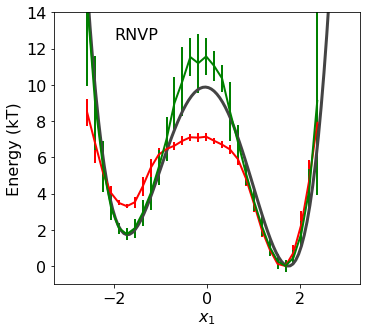

In [144]:
hist_x, hists_y, whist_x, whists_y = sample_energy(bg_unbiased_RNVP, 100000, 20, nbins=30)
fig = plot_energy(target, hist_x, hists_y, whist_x, whists_y, ylabel=True, nstd=1.0, figsize=(5.5, 5))
plt.text(-2, 12.5, 'RNVP', fontsize=16);
#fig.savefig('../figs/2well/2well_rnvp.pdf', bb_inches='tight')

In [170]:
# NSF unbiased
stats = []
for i in range(10):
    bg_unbiased_NSF = boltzmann_generator_NSF_MC(prior, target, n_transform=3, tail=3, stochastic=False)
    stat = train_and_analyze(bg_unbiased_NSF, x_brute[::10])
    stats.append(stat)
    print(i, '\t', stat[0], '\t', stat[1], '\t', stat[2], '\t', stat[3])     
stats = np.array(stats)

/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:26: RuntimeWarning: divide by zero encountered in log
  whists_y.append(-np.log(whist_y))
/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:21: RuntimeWarning: divide by zero encountered in log
  hists_y.append(-np.log(hist_y))


0 	 0.7478663250172952 	 0.7966994696763925 	 0.540364409102099 	 1.6345228747400908
1 	 1.0946430334821007 	 0.9880336646380913 	 0.39216952826460283 	 1.887773582524758
2 	 1.2670361214887709 	 0.8624117989740825 	 0.5596886608617608 	 2.365902926149116
3 	 0.24974069274374355 	 1.043854873305405 	 0.5627017599394839 	 2.3476020011497596
4 	 0.93550151959584 	 0.9399947232686261 	 0.7968745275344773 	 1.9217952502381048
5 	 0.5107103492326509 	 1.0159719808427963 	 0.6213151265105481 	 2.130321926596586
6 	 0.934071150650148 	 0.7923677512174596 	 0.6304364587099681 	 1.6941519510769623
7 	 0.3813438016290657 	 1.176663341047027 	 0.32880373579050626 	 2.4102989405967823
8 	 0.6508009315570707 	 0.8663926776657243 	 0.42552779647745276 	 1.877650032292157
9 	 1.4037527346642589 	 1.2997227670422644 	 1.2051117445268773 	 3.202081562038341


In [171]:
print('    Bias       Unc        Bias rew   Unc rew')
print('  ', np.mean(stats, axis=0))
print('+-', np.std(stats, axis=0))
print()
ee_unweighted = np.sqrt(stats[:, 0]**2+stats[:, 1]**2)
ee_reweighted = np.sqrt(stats[:, 2]**2+stats[:, 3]**2)
print('sqrt(bias**2+std**2)\t', np.mean(ee_unweighted), '+-', np.std(ee_unweighted))
print('reweighted    \t', np.mean(ee_reweighted), '+-', np.std(ee_reweighted))

    Bias       Unc        Bias rew   Unc rew
   [0.81754667 0.9782113  0.60629937 2.1472101 ]
+- [0.35908726 0.1560263  0.23657086 0.43921861]

sqrt(bias**2+std**2)	 1.309506954947835 +- 0.2525060589681973
reweighted    	 2.238132824010196 +- 0.4666373208688057


/Users/noe/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


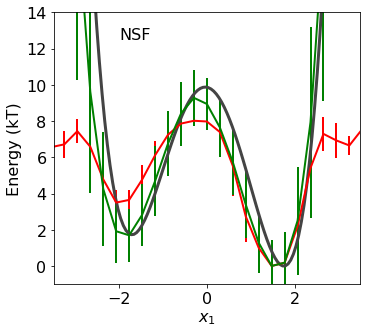

In [187]:
hist_x, hists_y, whist_x, whists_y = sample_energy(bg_unbiased_NSF, 100000, 20, nbins=30)
fig = plot_energy(target, hist_x, hists_y, whist_x, whists_y, ylabel=True, nstd=1.0, figsize=(5.5, 5))
plt.text(-2, 12.5, 'NSF', fontsize=16);
plt.xlim(-3.5, 3.5)
#fig.savefig('../figs/2well/2well_nsf.pdf', bb_inches='tight')

In [180]:
# RNVP + MC unbiased
stats_RNVP_MC = []
for i in range(10):
    bg_unbiased_MC = boltzmann_generator_RNVP_MC(prior, target, n_transform=3, shift_nhidden=[64, 64], scale_nhidden=[64, 64],
                                                 nrelax=20, stepsize=0.25, stochastic=True, diffuse_at_0=True)
    stat = train_and_analyze(bg_unbiased_MC, x_brute[::10])
    stats_RNVP_MC.append(stat)
    print(i, '\t', stat[0], '\t', stat[1], '\t', stat[2], '\t', stat[3])    
stats_RNVP_MC = np.array(stats_RNVP_MC)

0 	 1.404324404778081 	 0.4299607049326662 	 0.22949396877383685 	 0.8186179083567348
1 	 1.5847878169750678 	 0.25123776126231134 	 0.08162359567207632 	 0.6137874388405262
2 	 1.5870265209533367 	 0.2318096730739754 	 0.06448716953364535 	 0.5182814941654438
3 	 1.3496333568357557 	 0.22639991983457264 	 0.18947990056035113 	 0.5667422407187481
4 	 1.8873123512738441 	 0.2316892592804695 	 0.26606708809678986 	 0.7435324403062977
5 	 1.4038346338527483 	 0.22048693597767613 	 0.1345054716812012 	 0.5509562486473516
6 	 1.5107625122793606 	 0.22667142108292818 	 0.20820346990034952 	 0.5372218427632001
7 	 1.101808561679312 	 0.2685345468555458 	 0.16436162833720294 	 0.6868670809324542
8 	 1.540456612340063 	 0.23402163928256617 	 0.003648335755094223 	 0.5672979084819896
9 	 1.451227393209257 	 0.23134067514053042 	 0.1303759810830746 	 0.5274754509701337


In [181]:
stats = stats_RNVP_MC
print('    Bias       Unc        Bias rew   Unc rew')
print('  ', np.mean(stats, axis=0))
print('+-', np.std(stats, axis=0))
print()
ee_unweighted = np.sqrt(stats[:, 0]**2+stats[:, 1]**2)
ee_reweighted = np.sqrt(stats[:, 2]**2+stats[:, 3]**2)
print('sqrt(bias**2+std**2)\t', np.mean(ee_unweighted), '+-', np.std(ee_unweighted))
print('reweighted          \t', np.mean(ee_reweighted), '+-', np.std(ee_reweighted))

    Bias       Unc        Bias rew   Unc rew
   [1.48211742 0.25521525 0.14722466 0.61307801]
+- [0.1911217  0.05975013 0.07674514 0.09740668]

sqrt(bias**2+std**2)	 1.50575462279289 +- 0.18603081012528944
reweighted          	 0.6339139450299965 +- 0.1052175334494796


Text(-4.5,4,'c')

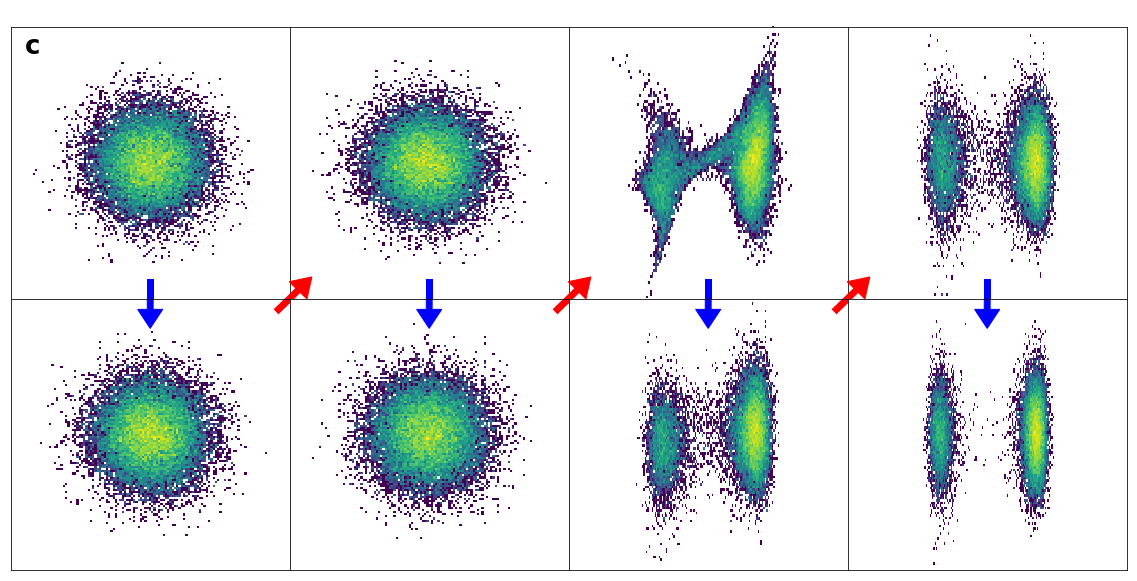

In [25]:
# Visualize forward flow with perturbation and relaxation 

# swap odd steps
z = prior.sample(20000, temperature=1.0)
samples_forward = sample_flow(bg_unbiased_MC.flow, z, inverse=False)
samples_forward[3] = np.hstack([samples_forward[3][:, 1:2], samples_forward[3][:, 0:1]])
samples_forward[6] = np.hstack([samples_forward[6][:, 1:2], samples_forward[6][:, 0:1]])
samples_forward[9] = np.hstack([samples_forward[9][:, 1:2], samples_forward[9][:, 0:1]])

indx = [0, 3, 6, 9]
fig, axes = plt.subplots(nrows=2, ncols=len(indx), sharex=True, sharey=True, figsize=(20, 10))
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in range(len(indx)):
    plot_samples(samples_forward[indx[i]], ax=axes[0, i])
    axes[0, i].set_yticks([])
    axes[1, i].set_yticks([])
    axes[0, i].set_xticks([])
    axes[1, i].set_xticks([])
    axes[0, i].set_xlim(-5, 5)
    axes[0, i].set_ylim(-5, 5)
    # blue arrow down
    axes[0, i].plot([0, 0], [-4.4, -5.0], linewidth=7, color='blue')
    axes[1, i].arrow(0, 5, 0, -0.4, width=0.21, head_width=0.9, head_length=0.7, color='blue')
    
    plot_samples(samples_forward[indx[i]+1], ax=axes[1, i])
    axes[1, i].set_xlim(-5, 5)
    axes[1, i].set_ylim(-5, 5)
    if i < len(indx)-1:
        axes[1, i].plot([4.6, 5], [4.6, 5], linewidth=7, color='red')
        axes[1, i].arrow(4.9, 4.9, 0.4, 0.4, width=0.21, head_width=0.9, head_length=0.7, color='red', clip_on=False)
axes[0, 0].text(-4.5, 4, 'c', fontsize=26, fontweight='bold')        

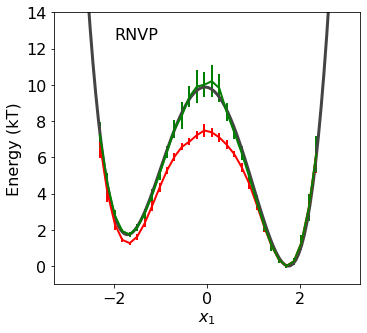

In [145]:
hist_x, hists_y, whist_x, whists_y = sample_energy(bg_unbiased_MC, 100000, 20, nbins=30)
fig = plot_energy(target, hist_x, hists_y, whist_x, whists_y, ylabel=True, nstd=1.0, figsize=(5.5, 5))
plt.text(-2, 12.5, 'RNVP + MC', fontsize=16);
#fig.savefig('../figs/2well/2well_rnvp_metro.pdf', bb_inches='tight')

In [178]:
# NSF + MC unbiased
stats_NSF_MC = []
for i in range(10):
    bg_unbiased_MC2 = boltzmann_generator_NSF_MC(prior, target, n_transform=3, tail=3,
                                                nrelax=20, stepsize=0.25, stochastic=True, diffuse_at_0=True)
    stat = train_and_analyze(bg_unbiased_MC2, x_brute[::10])
    stats_NSF_MC.append(stat)
    print(i, '\t', stat[0], '\t', stat[1], '\t', stat[2], '\t', stat[3])   
stats_NSF_MC = np.array(stats_NSF_MC)    

/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:21: RuntimeWarning: divide by zero encountered in log
  hists_y.append(-np.log(hist_y))
/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:26: RuntimeWarning: divide by zero encountered in log
  whists_y.append(-np.log(whist_y))


0 	 0.015415787996765089 	 0.5878118933508459 	 0.2265741591259159 	 0.7370808470892141
1 	 0.9700939124354738 	 0.33481441749183116 	 0.030258907509223634 	 0.4498981000729443
2 	 0.4864309238946638 	 0.4485232615797843 	 0.10264041413660012 	 0.4911227690317485
3 	 0.6084771874902924 	 0.366366576592879 	 0.04649704607494735 	 0.44280208610602595
4 	 0.14386127120818146 	 0.6908963660761382 	 0.12040610590948216 	 0.8869574660583996
5 	 0.6823304097900577 	 0.4281492864890554 	 0.004012520231554155 	 0.6211600329504654
6 	 0.3614480032485122 	 0.6101213780143923 	 0.1685651696344511 	 0.7909457824686847
7 	 0.003118812106014249 	 0.3247396581917501 	 0.049030802994095186 	 0.452354299888478
8 	 0.936822903064616 	 0.3618461028182565 	 0.008124110707069606 	 0.6253564005315773
9 	 0.23403873948517415 	 0.35148505090837623 	 0.002272191039450089 	 0.4471159044804381


In [179]:
stats = stats_NSF_MC
print('    Bias       Unc        Bias rew   Unc rew')
print('  ', np.mean(stats, axis=0))
print('+-', np.std(stats, axis=0))
print()
ee_unweighted = np.sqrt(stats[:, 0]**2+stats[:, 1]**2)
ee_reweighted = np.sqrt(stats[:, 2]**2+stats[:, 3]**2)
print('sqrt(bias**2+std**2)\t', np.mean(ee_unweighted), '+-', np.std(ee_unweighted))
print('reweighted    \t', np.mean(ee_reweighted), '+-', np.std(ee_reweighted))

    Bias       Unc        Bias rew   Unc rew
   [0.4442038  0.4504754  0.07583814 0.59447937]
+- [0.33531266 0.12512719 0.07268932 0.15577252]

bias**2+std**2	 0.6957880842198161 +- 0.21027465463985145
reweighted    	 0.6021512410185115 +- 0.16161634036243888


In [165]:
bg_unbiased_MC2 = boltzmann_generator_NSF_MC(prior, target, n_transform=3, tail=3,
                                                nrelax=20, stepsize=0.25, stochastic=True, diffuse_at_0=True)
train_and_analyze(bg_unbiased_MC2, x_brute[::10])

/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:21: RuntimeWarning: divide by zero encountered in log
  hists_y.append(-np.log(hist_y))
/Users/noe/data/papers/WuEtAl_StochasticFlows/revision/code_submission_rev/snf_code/snf_code/analysis.py:26: RuntimeWarning: divide by zero encountered in log
  whists_y.append(-np.log(whist_y))


(0.18433785036471081,
 0.3983317970851355,
 0.03495418084256403,
 0.891440134004567)

/Users/noe/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


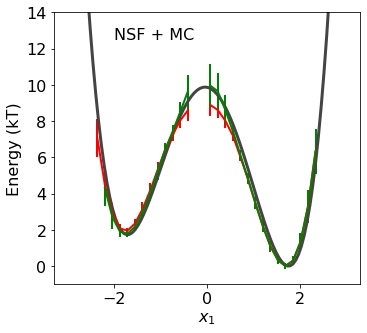

In [166]:
hist_x, hists_y, whist_x, whists_y = sample_energy(bg_unbiased_MC2, 100000, 20, nbins=30)
fig = plot_energy(target, hist_x, hists_y, whist_x, whists_y, ylabel=True, nstd=1.0, figsize=(5.5, 5))
plt.text(-2, 12.5, 'NSF + MC', fontsize=16);
#fig.savefig('../figs/2well/2well_nsf_metro.pdf', bb_inches='tight')